In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
from PIL import Image

from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML
import pickle
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

from mtcnn.mtcnn import MTCNN
# print version

import cv2
import copy

from tqdm import tqdm
import glob

Using TensorFlow backend.


In [2]:
def print_conf_mat(conf_mat,labels,filename = ""):
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat,cmap = plt.cm.summer)
    for i, row in enumerate(conf_mat):
            for j, c in enumerate(row):
                if c>0:
                    plt.text(j-.2, i+.1, c, fontsize=16)

    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename+'.eps')
    plt.show()

In [3]:
class Image():
    
    def __init__(self, image, landmarks, name):
        # self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.image = image
        self.original_image = copy.deepcopy(self.image)
        self.landmarks = landmarks
        self.name = name
        self.neutralised_image = np.array([])
        self.hash = hash(self)
    
    def setNeutralisedImage(self, image):
        self.neutralised_image = image
        
    def getNeutralisedImage(self):
        return self.neutralised_image
        
    def getName(self):
        return self.name
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getLandmarks(self):
        return self.landmarks
    
    def getHash(self):
        return self.hash

In [4]:
def getLandmarksForImage(imagePath):
    cur_landmark = "\\".join(str(imagePath).rsplit('\\',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '\\' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks


def view_landmarks(landmarks, color='r'):
    xs, ys = list(zip(*landmarks))
    plt.scatter(xs, ys, color=color)
    return 

In [5]:
base_path = "..\\Data"

In [6]:
ck_data_path = base_path + '\\CK+\\cohn-kanade-images'
ck_landmarks_path = base_path + '\\CK+\\Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

#ck_image_files = ck_image_files[7000:]

In [7]:
len(ck_image_files)

10708

In [8]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [9]:
images = []
crop_imsize = 160

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):
        

        landmarks = getLandmarksForImage(ck_image)
        image, landmarks = detect_face(ck_image, landmarks)
        image = cv2.resize(image,(crop_imsize, crop_imsize))
        images.append(Image(image, landmarks, ck_image))
        
        pbar.update(1)

Processing entries: 100%|████████████████████████████████████████████████████████| 10708/10708 [29:49<00:00,  5.98it/s]


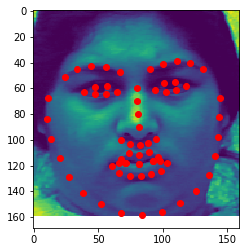

In [10]:
plt.imshow(images[1].getImage())
view_landmarks(images[1].getLandmarks())

In [11]:
numImages = len(images)

avgLandmarks = (images[0].getLandmarks() / numImages)

for image in images[1:]:
    avgLandmarks += (image.getLandmarks()) / numImages

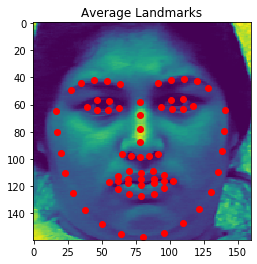

In [12]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks)

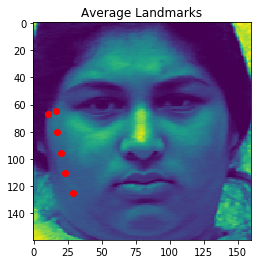

In [13]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks[:5])
view_landmarks(images[0].getLandmarks()[:1])

In [14]:
def appendLastRowAsCol(npMatrix):
    return np.c_[npMatrix[:-1,:].T, np.array([npMatrix[-1,:]]).T ]

In [15]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    triangle_im = im
    triangle_mask = np.zeros_like(im)

    triangle_mask_fill_points = np.array([
            [pt1[0], pt1[1]],
            [pt2[0], pt2[1]],
            [pt3[0], pt3[1]]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
    
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
        
    return cropped_triangle

def drawTriangle(im, triangle_points_array, color):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    
    cv2.line(im, pt1, pt2, color, 2)
    cv2.line(im, pt1, pt3, color, 2)
    cv2.line(im, pt3, pt2, color, 2)

def draw_delaunay(im, subdiv_triangles, color):

    for t in subdiv_triangles:
        drawTriangle(im, t, color)

def get_second_delaunay_triangles(im, src_triangles, src_landmarks, dest_landmarks):
    src_landmarks = np.array(src_landmarks).astype(np.float32)

    dest_triangles = np.array([[1,2,3,4,5,6]])
    for t in src_triangles:
        pt1 = np.array([t[0], t[1]])
        pt2 = np.array([t[2], t[3]])
        pt3 = np.array([t[4], t[5]])
  
        index_pt1 = np.where((pt1 == src_landmarks).all(axis=1))[0][0]
        index_pt2 = np.where((pt2 == src_landmarks).all(axis=1))[0][0]
        index_pt3 = np.where((pt3 == src_landmarks).all(axis=1))[0][0]

        dest_triangle = np.array([dest_landmarks[index_pt1], dest_landmarks[index_pt2], dest_landmarks[index_pt3]]).flatten()
        dest_triangles = np.concatenate((dest_triangles, np.array([dest_triangle])), axis=0)
    
    return dest_triangles[1:]

In [16]:
DRAW_EXAMPLE = False

dest = list(map(lambda x: tuple(x),avgLandmarks))

with tqdm(total=len(images), desc="Neutralizing emotions") as pbar:

    for image in images[:]:
        src = list(map(lambda x: tuple(x),image.getLandmarks()))

        image.clearImage()
        im = image.getImage()
        im_shape = im.shape

        rect = (0,0,im_shape[1],im_shape[0])
        subdiv = cv2.Subdiv2D(rect)
        
        try:
            subdiv.insert(src)
        except:
            pbar.update(1)
            continue
            
        src_triangles = subdiv.getTriangleList()

        dest_triangles = get_second_delaunay_triangles(im, src_triangles, src, dest)

        warped_image = np.zeros_like(im)      
        for (src_triangle, dest_triangle) in zip(src_triangles, dest_triangles):
            ## Change this code
            src_triangle = src_triangle.reshape(3,2).astype(np.float32)
            dest_triangle = dest_triangle.reshape(3,2).astype(np.float32)

            M = cv2.getAffineTransform(src_triangle, dest_triangle)

            src_triangle_image = getTriangleImage(im, src_triangle.flatten())

            dest_boundingRect = cv2.boundingRect(dest_triangle)
            (dx, dy, dw, dh) = dest_boundingRect

            warped_image_triangle = cv2.warpAffine(src_triangle_image, M,  src_triangle_image.shape)

            warped_triangle_area = warped_image[dy: dy + dh, dx : dx + dw]        
            warped_triangle_area = cv2.add(warped_triangle_area, warped_image_triangle[dy: dy + dh, dx : dx + dw])

            warped_image[dy: dy + dh, dx : dx + dw] = warped_triangle_area

        image.setNeutralisedImage(warped_image)
        pbar.update(1)

        if DRAW_EXAMPLE:
            print("DRAW_EXAMPLE IS TRUE")
            pairPlot(warped_image,im )
            break

Neutralizing emotions: 100%|█████████████████████████████████████████████████████| 10708/10708 [03:27<00:00, 51.61it/s]


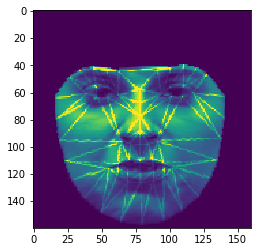

In [17]:
plt.imshow(images[257].getNeutralisedImage())

In [18]:
images[0].getName()

'..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000001.png'

In [19]:
import os
from PIL import Image

with tqdm(total=len(images), desc="Saving Neutralized emotions") as pbar:

    for image in images:

        path = "NeutralisedImages" + image.getName().split("Data")[-1]
        directory = "\\".join(path.split("\\")[:-1])

        if not os.path.exists(directory):
            os.makedirs(directory)

        try:
            im = Image.fromarray(image.getNeutralisedImage())
            im.save(path)
            pbar.update(1)
        except:
            
            pbar.update(1)
            continue


Saving Neutralized emotions: 100%|██████████████████████████████████████████████| 10708/10708 [00:15<00:00, 700.81it/s]


In [20]:
neutralized_image_files = glob.glob('NeutralisedImages\\CK+\\cohn-kanade-images/**/*.png', recursive=True)
len(neutralized_image_files)

10698

In [21]:
neutralized_image_files[1].split('\\')[3]

'S005'

In [22]:
def detect_face(f,required_size=(160, 160)):
    ''' function to detect face, crop the image and resize it '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    
    image = Image.fromarray(gray)
    image = image.resize(required_size)
    image = image.convert('RGB')
    face_array = np.asarray(image)
    return face_array

In [23]:
faces_ck = list()
labels_ck  = list()
tmp_lab_prev = ''
tmp_lab = ''
for i in tqdm(range(len(neutralized_image_files))):
    i_im = neutralized_image_files[i]
    tmp_lab = i_im.split('\\')[3]
    '''if(tmp_lab != tmp_lab_prev):
        print('Started pre-processing with subject:'+ tmp_lab)
    '''
    face = detect_face(i_im)
    
     
    labels_ck.append(tmp_lab)
    
    # store
    faces_ck.append(face)
    tmp_lab_prev = tmp_lab
    

100%|██████████████████████████████████████████████████████████████████████████| 10698/10698 [00:06<00:00, 1631.18it/s]


In [24]:
X_full_ck = np.asarray(faces_ck)

In [25]:
l_full_ck = np.asarray(labels_ck)

In [26]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_full_ck, l_full_ck, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8558, 160, 160, 3), (2140, 160, 160, 3), (8558,), (2140,))

In [27]:
# save arrays to one file in compressed format
np.savez_compressed('ck+dataset-neutralized.npz', X_train, y_train, X_test, y_test)

In [28]:
# load the face dataset
data = np.load('ck+dataset-neutralized.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (8558, 160, 160, 3) (8558,) (2140, 160, 160, 3) (2140,)


# Load pre-trained FaceNET model

In [29]:
model = load_model('..\\Data\\Model\\model\\facenet_keras.h5')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [30]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]


# Use FaceNet to generate embeddings for each image

In [31]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [32]:
# convert each face in the train set to an embedding
newTrainX = list()
for i in tqdm(range(trainX.shape[0])):
    face_pixels = trainX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
        '''
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 8558/8558 [10:20<00:00, 13.80it/s]


(8558, 128)


In [33]:
# convert each face in the test set to an embedding
newTestX = list()
for i in tqdm(range(testX.shape[0])):
    face_pixels = testX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
    '''
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2140/2140 [02:36<00:00, 13.69it/s]


(2140, 128)


In [34]:
# save arrays to one file in compressed format
np.savez_compressed('ck+-faces-embeddings-neutralized.npz', newTrainX, trainy, newTestX, testy)

# Train an SVM to do the recognition

In [35]:
# load necessary libraries
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

In [36]:
# load faces
data = load('ck+dataset-neutralized.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('ck+-faces-embeddings-neutralized.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model_SVM = SVC(gamma=2, C=1, probability=True)
model_SVM.fit(trainX, trainy)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Performance evaluation

In [37]:
# prediction vector for the test set
yhat_accuracy = model_SVM.score(testX, testy)
print("Accuracy on test set = "+str(yhat_accuracy*100) + "%")

Accuracy on test set = 100.0%


In [38]:
y_pred_shape_free = model_SVM.predict(testX)
c_mat_val = confusion_matrix(testy, y_pred_shape_free)
c_mat_val

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0, 22,  0, ...,  0,  0,  0],
       [ 0,  0, 12, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 25,  0,  0],
       [ 0,  0,  0, ...,  0,  2,  0],
       [ 0,  0,  0, ...,  0,  0, 20]], dtype=int64)

## Results on some random samples from test set

1108
Predicted: S109 (62.500)
Expected: S109


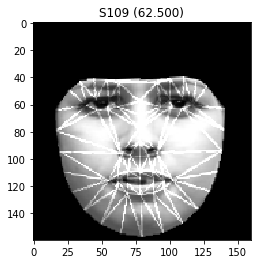

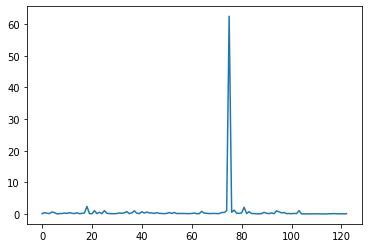

761
Predicted: S067 (77.009)
Expected: S067


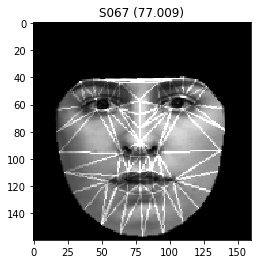

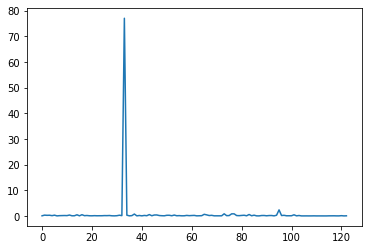

524
Predicted: S010 (63.891)
Expected: S010


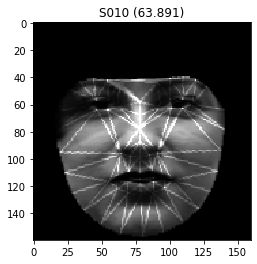

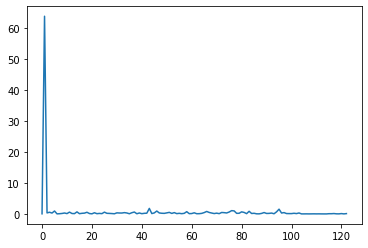

845
Predicted: S034 (62.273)
Expected: S034


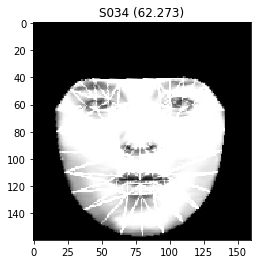

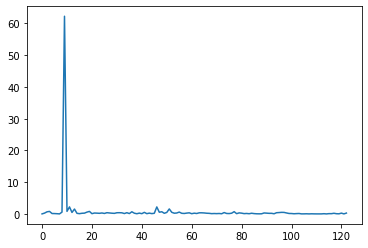

667
Predicted: S055 (70.787)
Expected: S055


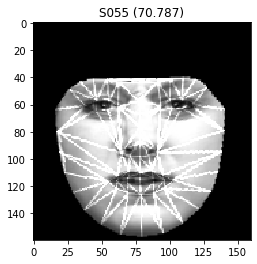

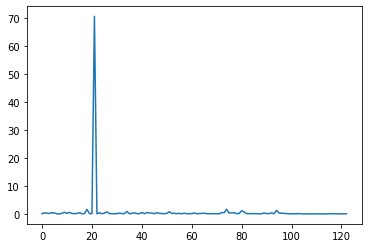

758
Predicted: S088 (30.420)
Expected: S088


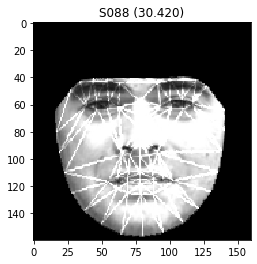

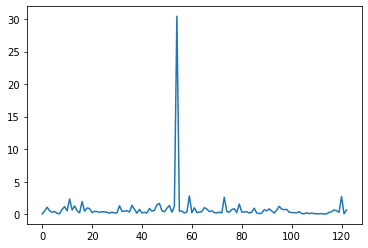

173
Predicted: S113 (74.952)
Expected: S113


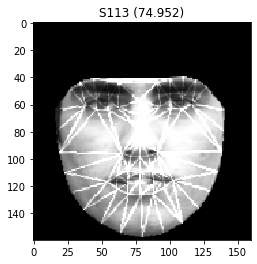

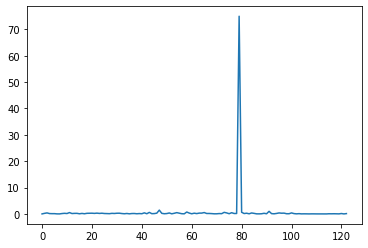

1358
Predicted: S082 (61.209)
Expected: S082


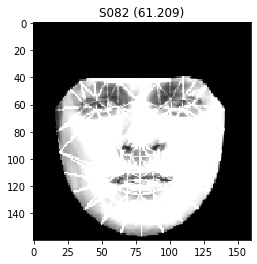

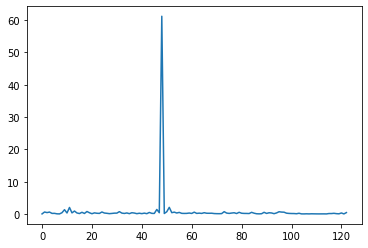

1193
Predicted: S045 (74.811)
Expected: S045


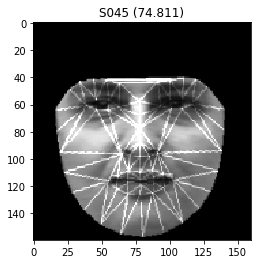

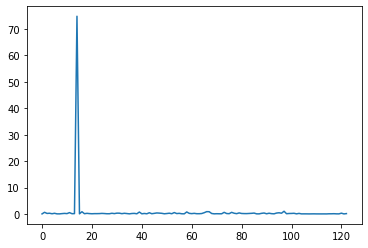

1687
Predicted: S034 (52.983)
Expected: S034


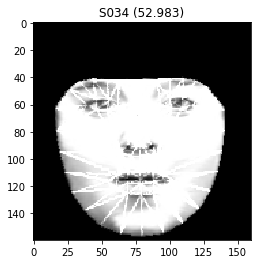

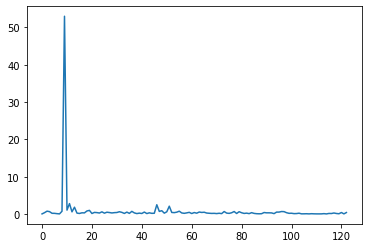

1013
Predicted: S999 (18.938)
Expected: S999


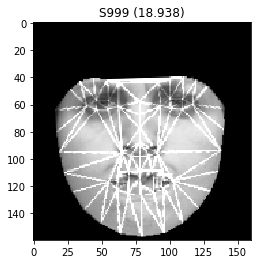

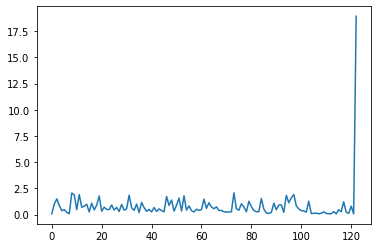

372
Predicted: S057 (73.346)
Expected: S057


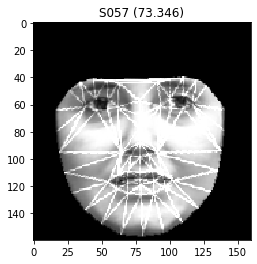

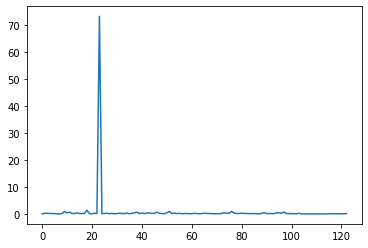

1265
Predicted: S066 (29.375)
Expected: S066


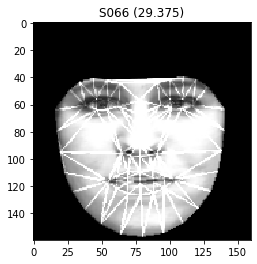

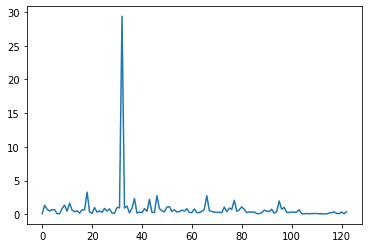

1665
Predicted: S105 (62.318)
Expected: S105


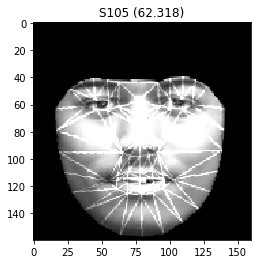

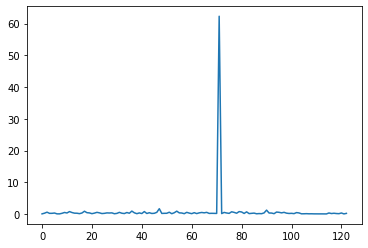

63
Predicted: S046 (51.832)
Expected: S046


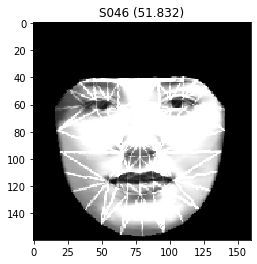

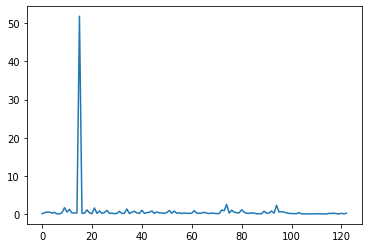

127
Predicted: S114 (67.603)
Expected: S114


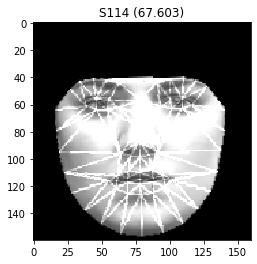

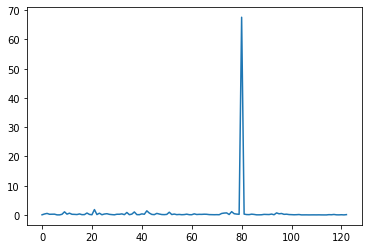

1542
Predicted: S056 (40.266)
Expected: S056


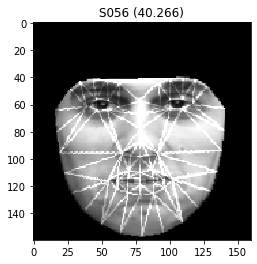

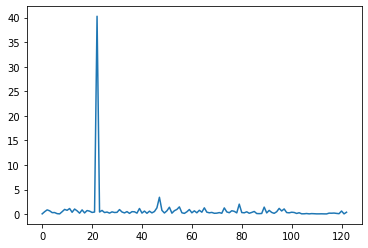

2078
Predicted: S034 (65.799)
Expected: S034


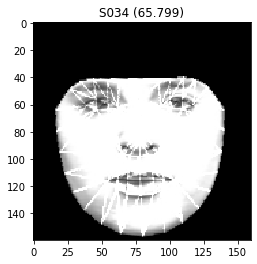

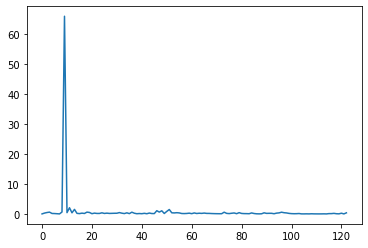

383
Predicted: S076 (55.144)
Expected: S076


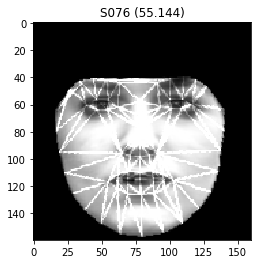

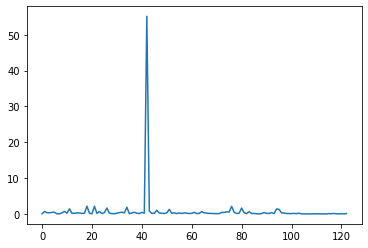

712
Predicted: S115 (75.823)
Expected: S115


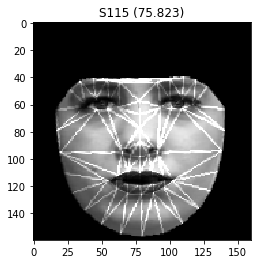

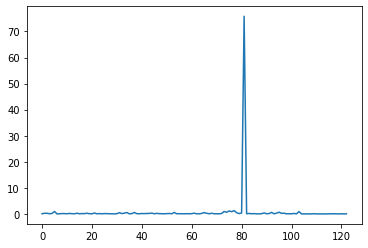

1113
Predicted: S127 (47.519)
Expected: S127


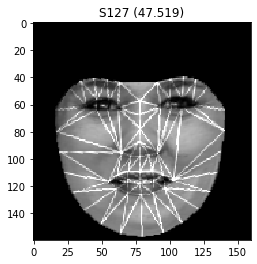

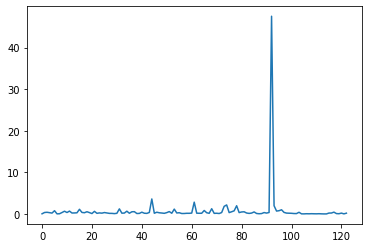

401
Predicted: S067 (70.337)
Expected: S067


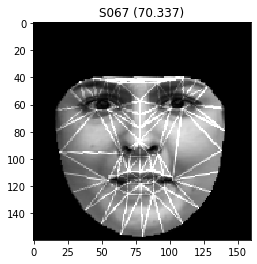

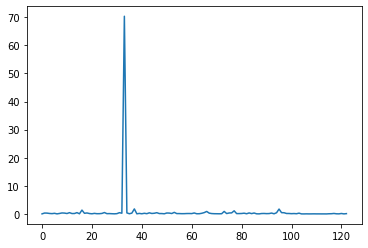

1717
Predicted: S130 (86.825)
Expected: S130


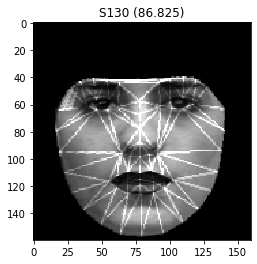

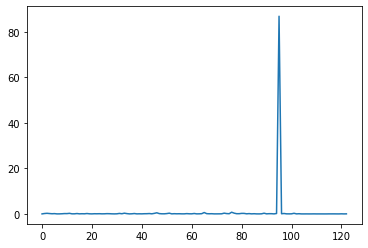

676
Predicted: S098 (32.850)
Expected: S098


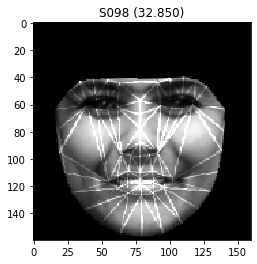

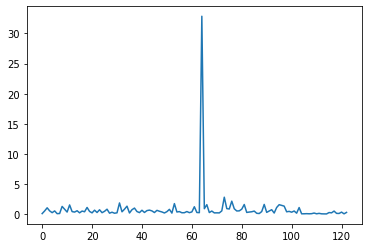

48
Predicted: S088 (40.591)
Expected: S088


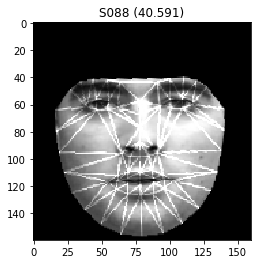

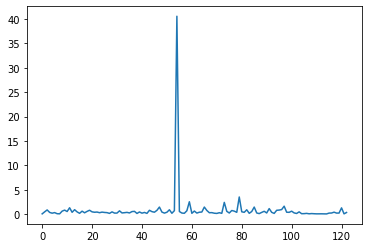

2049
Predicted: S086 (21.365)
Expected: S086


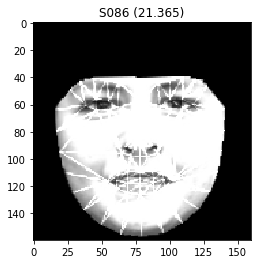

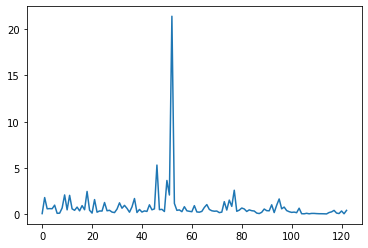

1611
Predicted: S501 (72.883)
Expected: S501


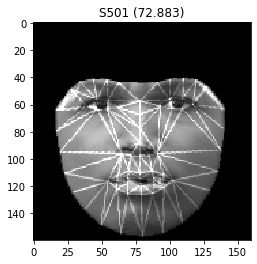

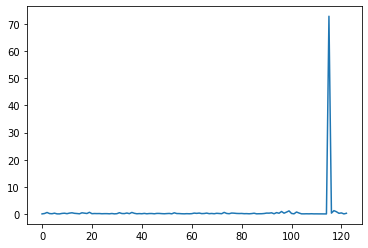

2045
Predicted: S129 (58.119)
Expected: S129


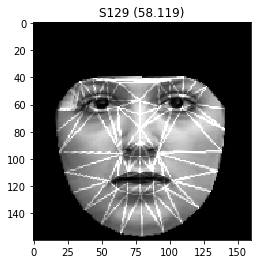

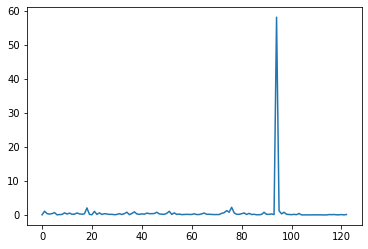

327
Predicted: S046 (46.736)
Expected: S046


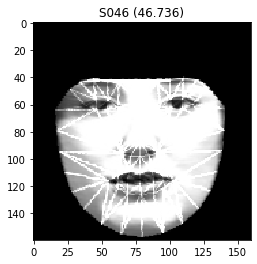

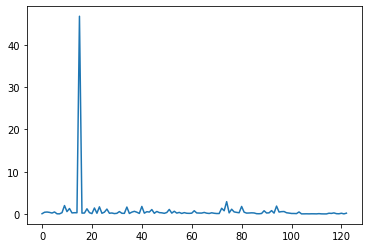

490
Predicted: S127 (72.495)
Expected: S127


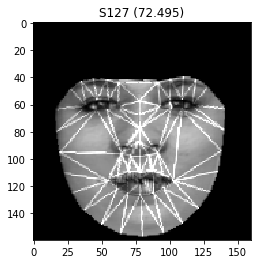

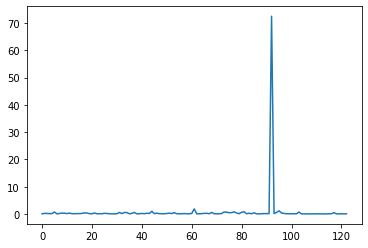

822
Predicted: S103 (61.763)
Expected: S103


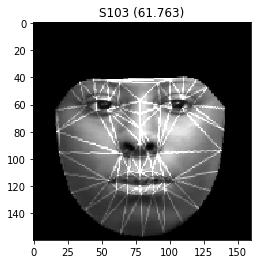

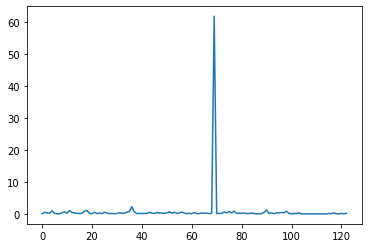

1661
Predicted: S122 (54.082)
Expected: S122


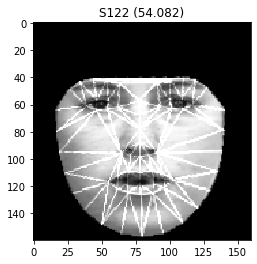

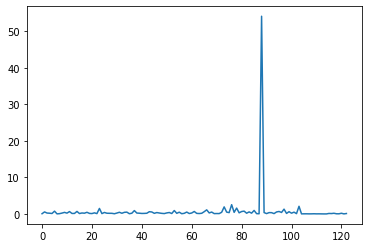

1773
Predicted: S136 (57.289)
Expected: S136


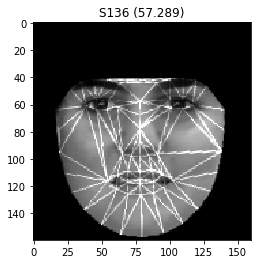

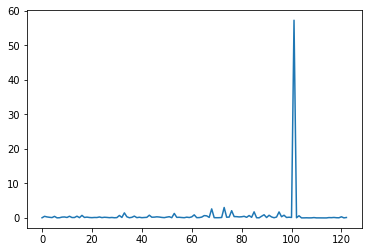

1133
Predicted: S069 (69.618)
Expected: S069


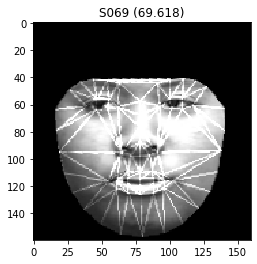

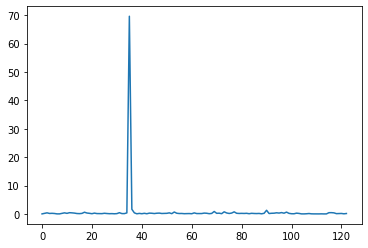

1440
Predicted: S101 (48.820)
Expected: S101


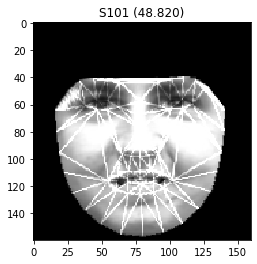

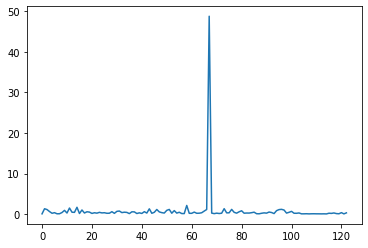

737
Predicted: S075 (70.052)
Expected: S075


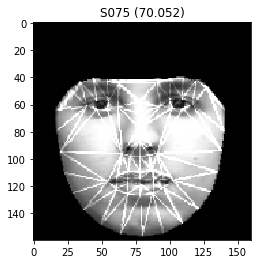

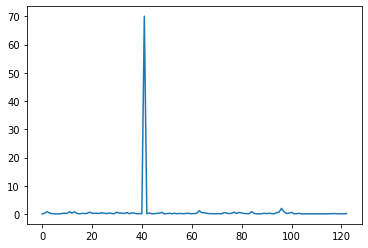

1131
Predicted: S108 (76.927)
Expected: S108


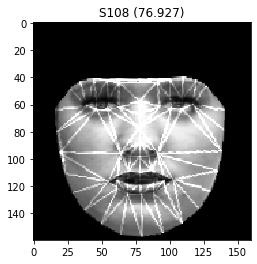

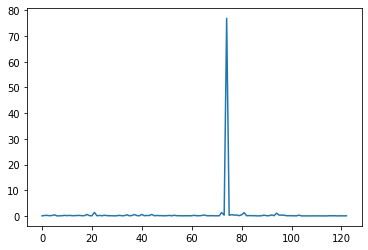

1678
Predicted: S125 (30.731)
Expected: S125


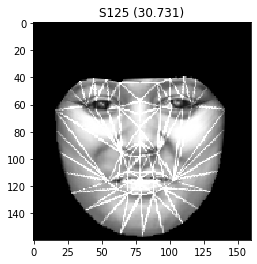

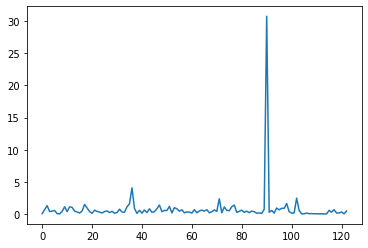

757
Predicted: S085 (33.503)
Expected: S085


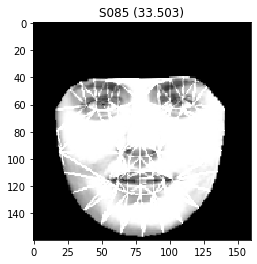

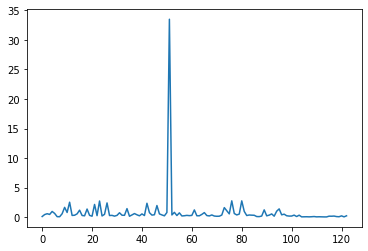

529
Predicted: S022 (70.902)
Expected: S022


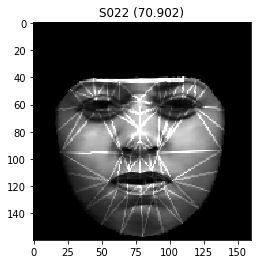

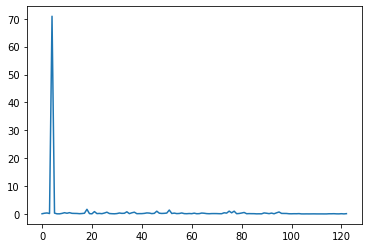

796
Predicted: S064 (51.159)
Expected: S064


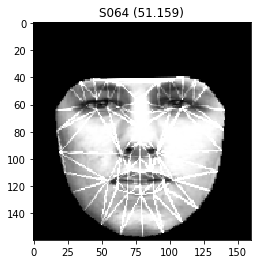

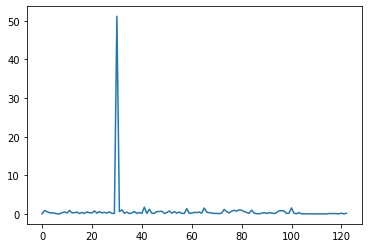

937
Predicted: S095 (59.814)
Expected: S095


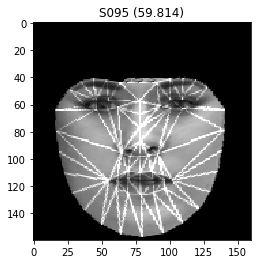

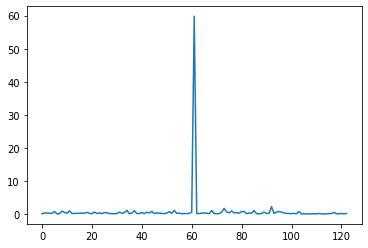

1690
Predicted: S014 (24.758)
Expected: S014


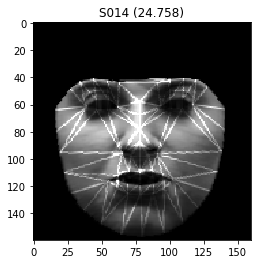

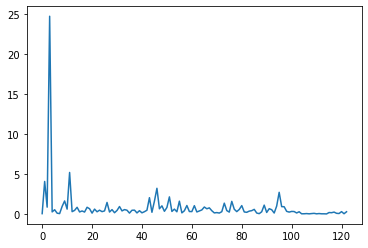

402
Predicted: S999 (41.957)
Expected: S999


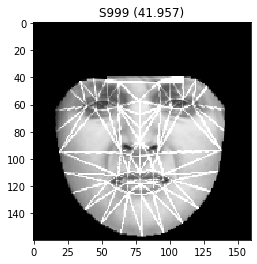

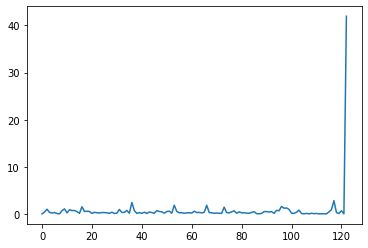

1715
Predicted: S061 (54.928)
Expected: S061


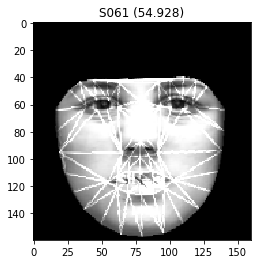

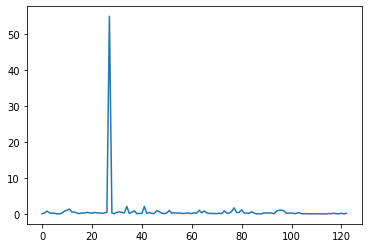

215
Predicted: S136 (54.181)
Expected: S136


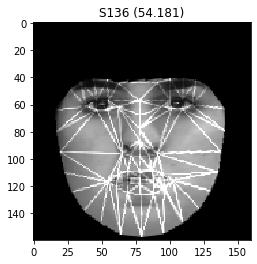

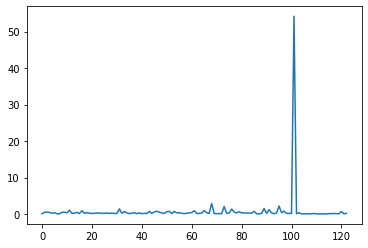

568
Predicted: S080 (38.006)
Expected: S080


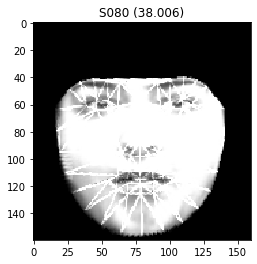

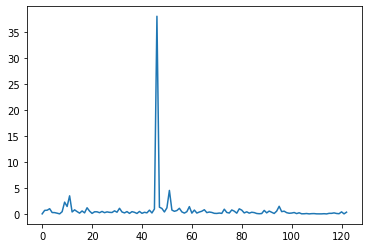

1772
Predicted: S087 (59.932)
Expected: S087


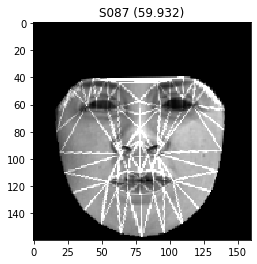

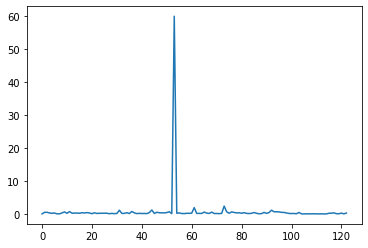

1995
Predicted: S108 (64.204)
Expected: S108


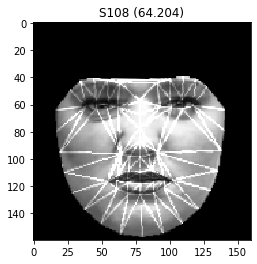

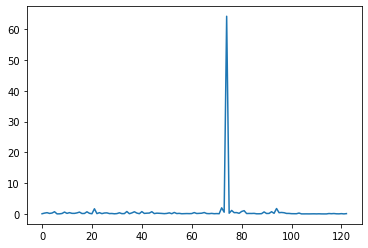

767
Predicted: S138 (51.283)
Expected: S138


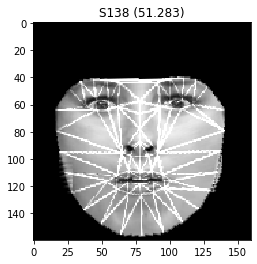

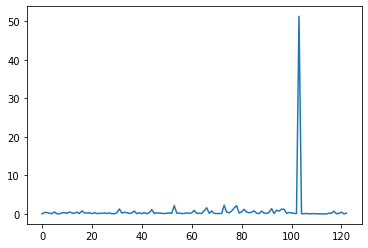

1219
Predicted: S059 (29.573)
Expected: S059


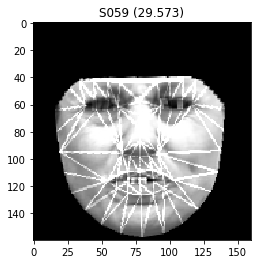

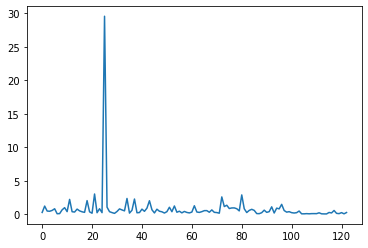

2011
Predicted: S127 (72.458)
Expected: S127


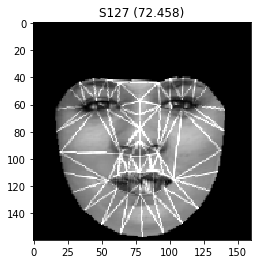

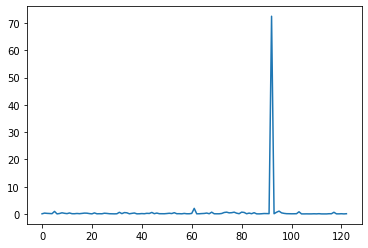

1244
Predicted: S044 (65.073)
Expected: S044


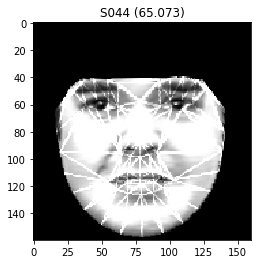

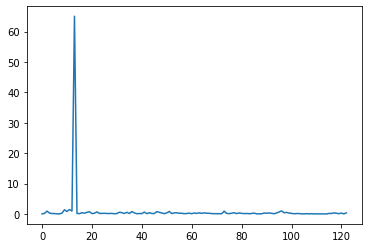

241
Predicted: S095 (82.500)
Expected: S095


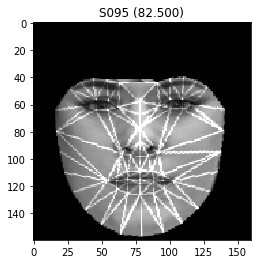

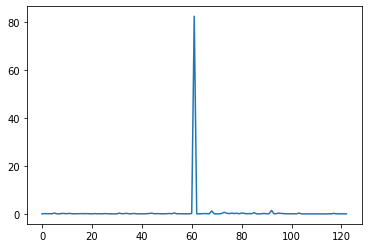

800
Predicted: S111 (53.356)
Expected: S111


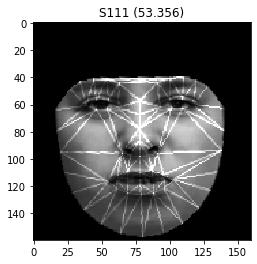

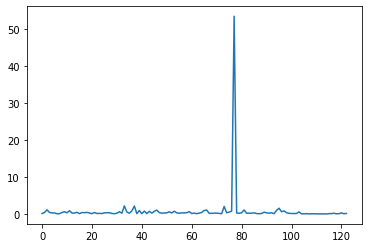

1608
Predicted: S109 (64.605)
Expected: S109


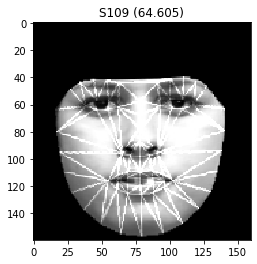

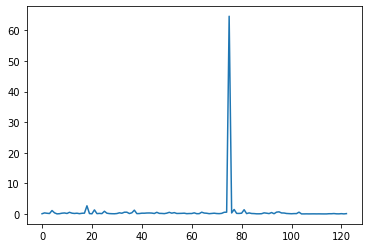

1456
Predicted: S116 (48.238)
Expected: S116


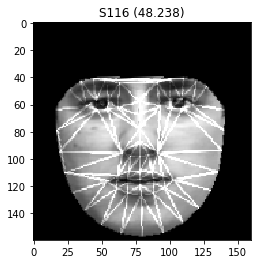

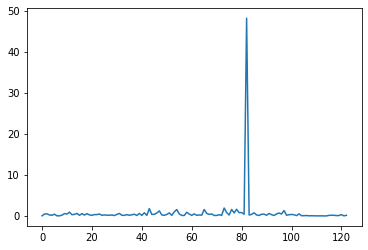

1274
Predicted: S121 (40.726)
Expected: S121


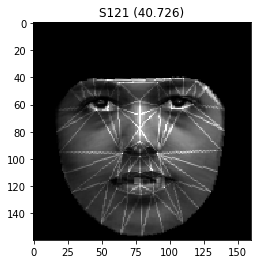

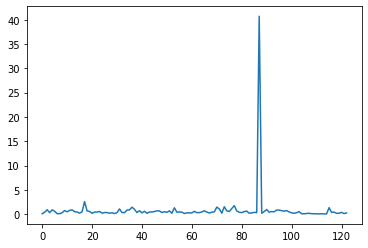

2092
Predicted: S073 (63.497)
Expected: S073


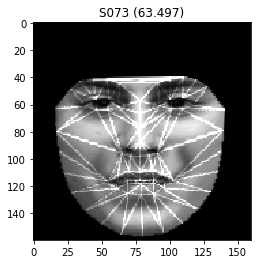

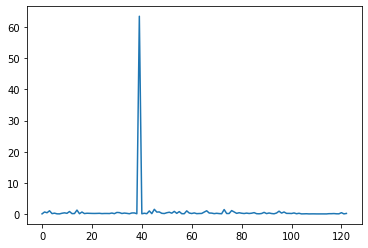

576
Predicted: S157 (15.510)
Expected: S157


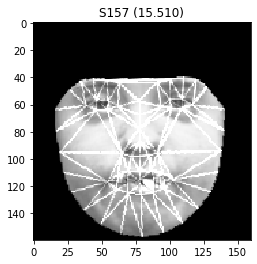

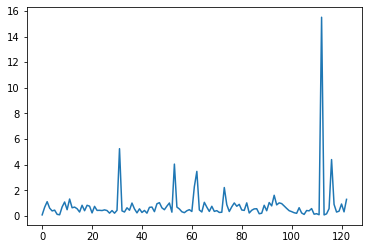

1475
Predicted: S071 (52.354)
Expected: S071


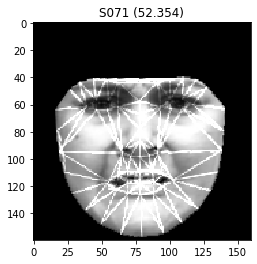

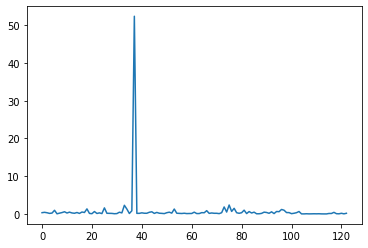

586
Predicted: S098 (44.819)
Expected: S098


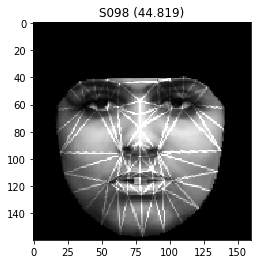

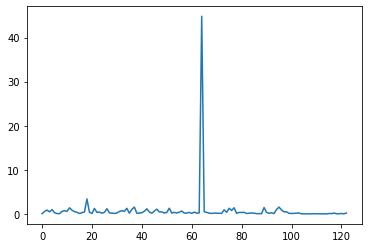

624
Predicted: S085 (39.274)
Expected: S085


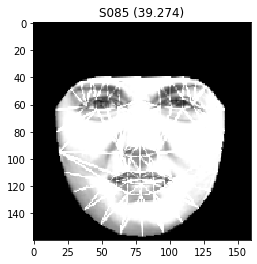

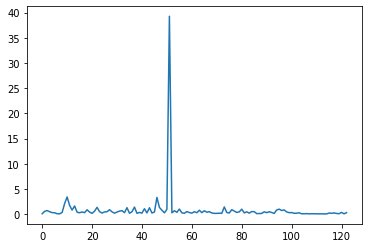

223
Predicted: S110 (60.954)
Expected: S110


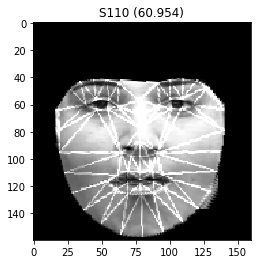

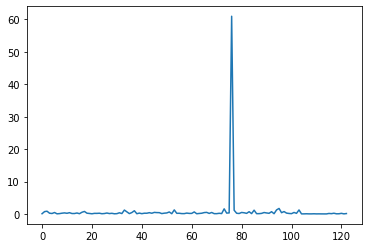

859
Predicted: S077 (71.523)
Expected: S077


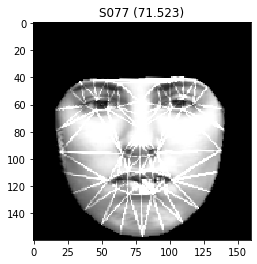

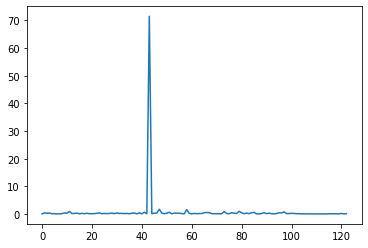

1860
Predicted: S505 (29.245)
Expected: S505


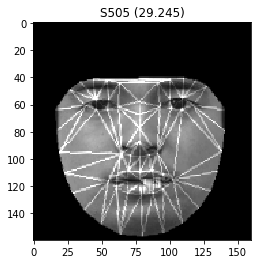

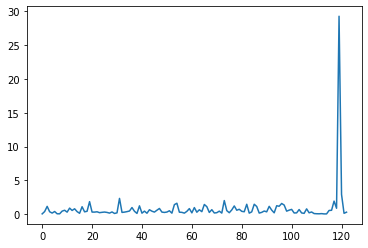

1579
Predicted: S129 (64.777)
Expected: S129


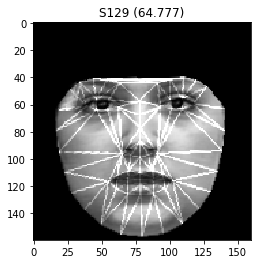

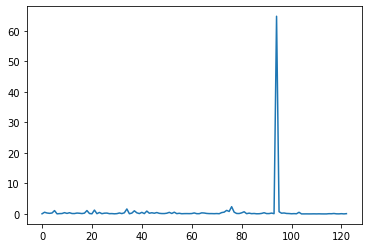

1139
Predicted: S071 (73.970)
Expected: S071


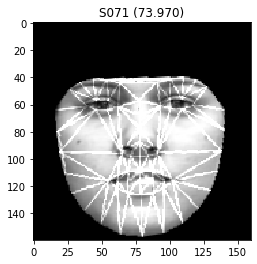

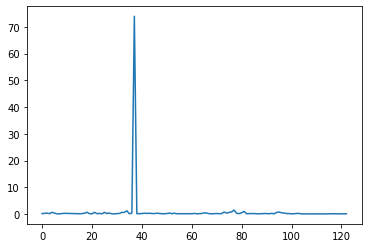

503
Predicted: S094 (28.836)
Expected: S094


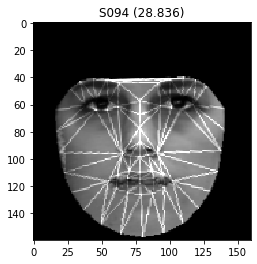

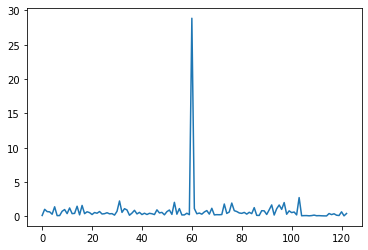

987
Predicted: S084 (40.511)
Expected: S084


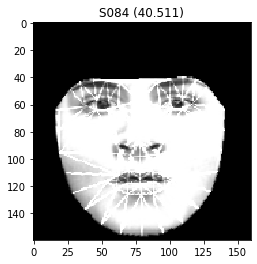

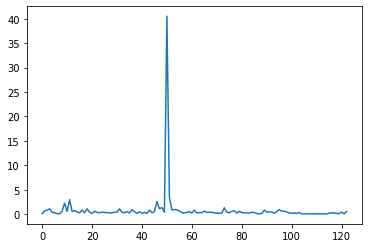

1361
Predicted: S034 (64.557)
Expected: S034


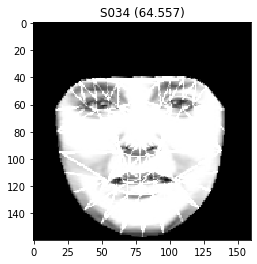

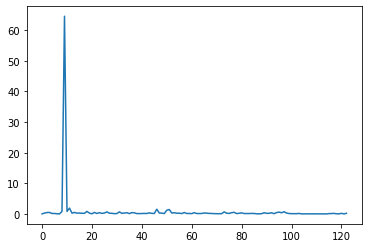

402
Predicted: S999 (41.957)
Expected: S999


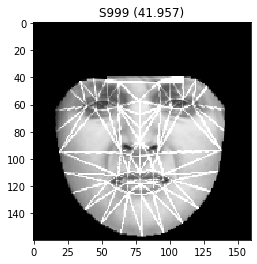

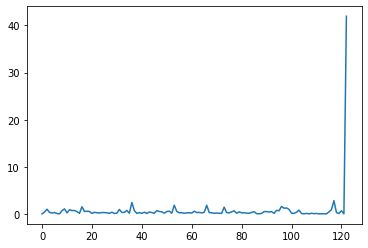

598
Predicted: S014 (66.797)
Expected: S014


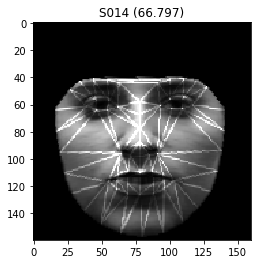

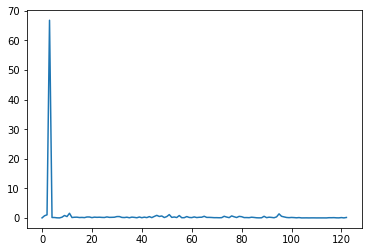

1433
Predicted: S014 (44.796)
Expected: S014


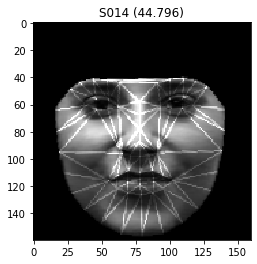

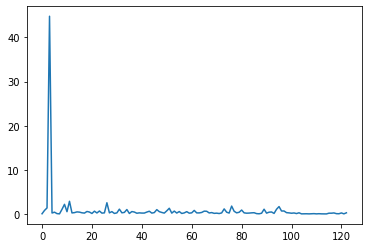

1109
Predicted: S132 (75.719)
Expected: S132


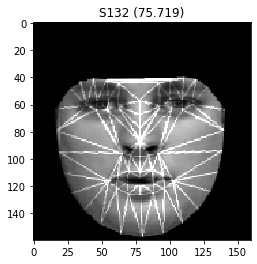

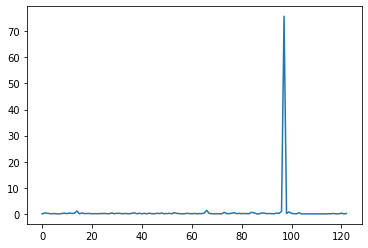

287
Predicted: S053 (64.701)
Expected: S053


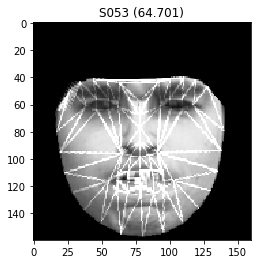

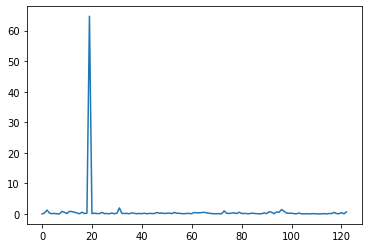

917
Predicted: S086 (27.234)
Expected: S086


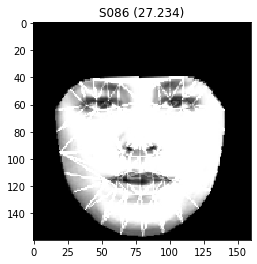

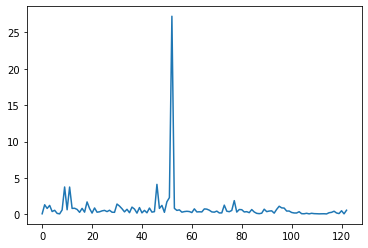

863
Predicted: S105 (54.915)
Expected: S105


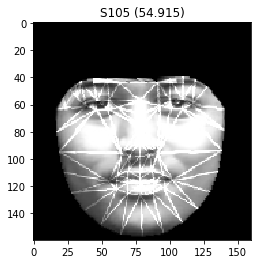

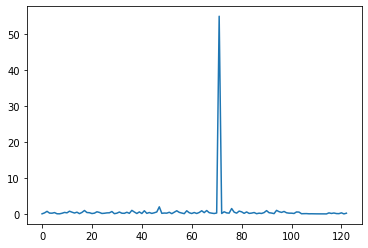

360
Predicted: S502 (62.151)
Expected: S502


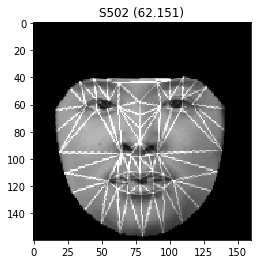

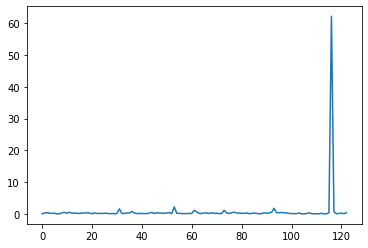

640
Predicted: S072 (53.379)
Expected: S072


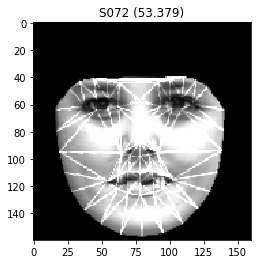

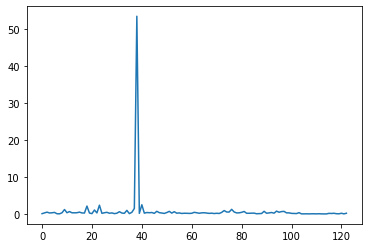

2061
Predicted: S502 (47.663)
Expected: S502


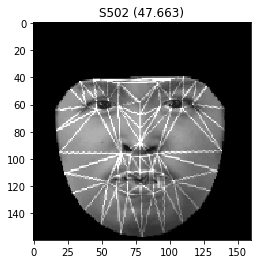

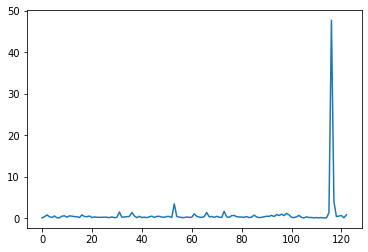

2026
Predicted: S119 (63.912)
Expected: S119


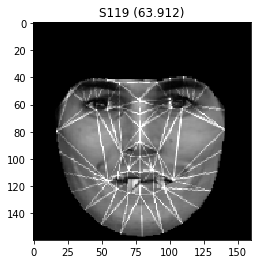

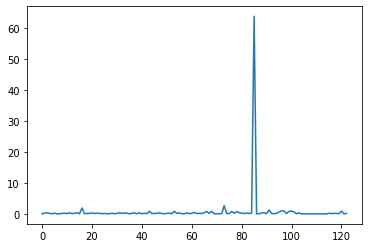

868
Predicted: S999 (41.292)
Expected: S999


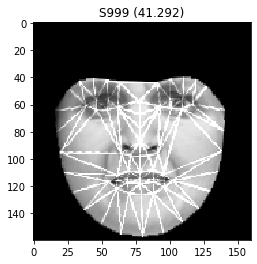

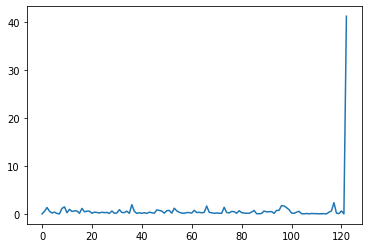

2109
Predicted: S102 (77.140)
Expected: S102


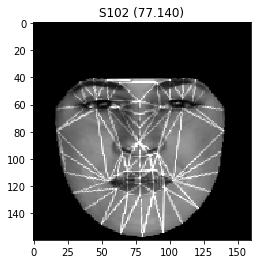

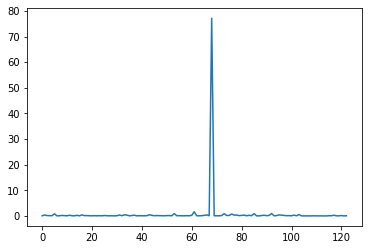

524
Predicted: S010 (63.891)
Expected: S010


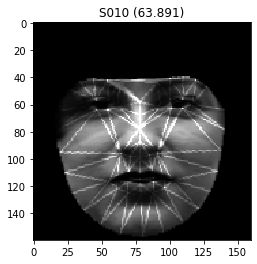

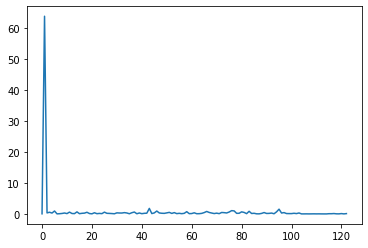

596
Predicted: S098 (36.745)
Expected: S098


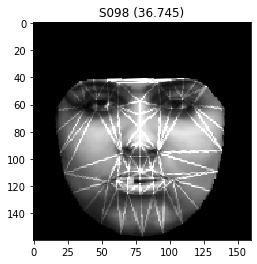

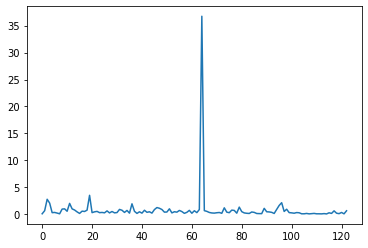

1449
Predicted: S110 (69.129)
Expected: S110


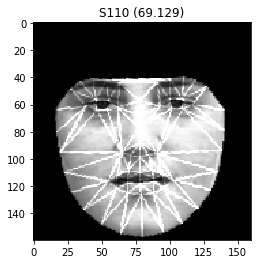

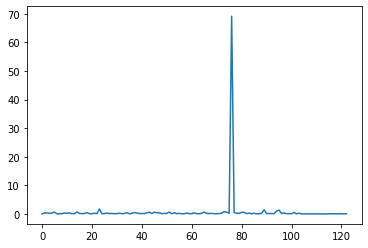

1958
Predicted: S106 (64.787)
Expected: S106


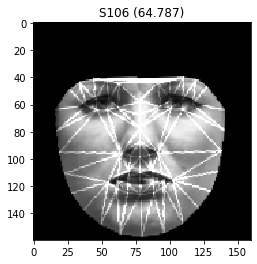

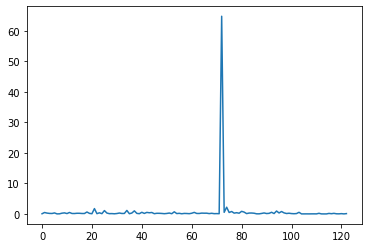

948
Predicted: S059 (58.307)
Expected: S059


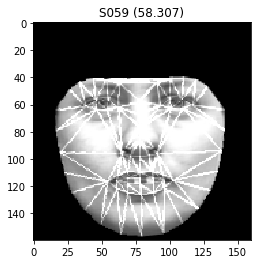

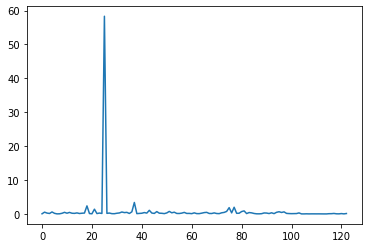

2077
Predicted: S082 (82.128)
Expected: S082


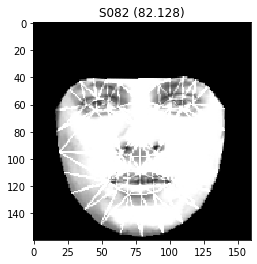

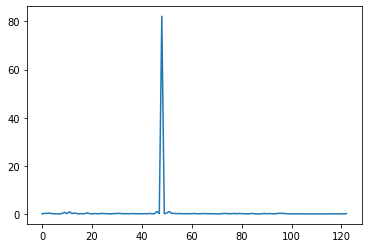

1969
Predicted: S128 (41.916)
Expected: S128


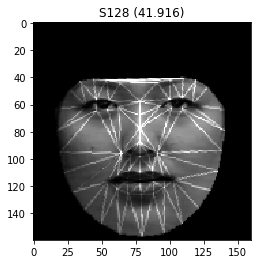

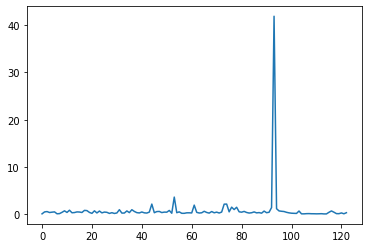

685
Predicted: S095 (75.934)
Expected: S095


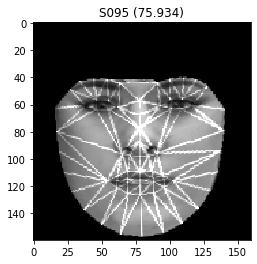

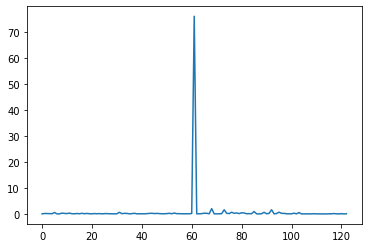

624
Predicted: S085 (39.274)
Expected: S085


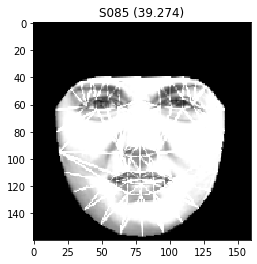

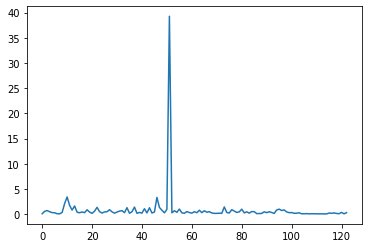

1308
Predicted: S126 (62.713)
Expected: S126


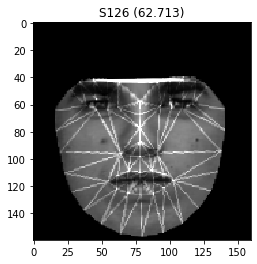

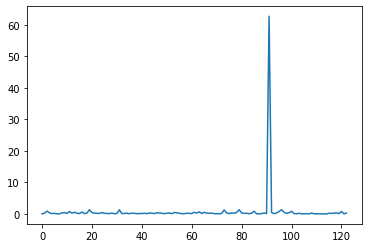

1848
Predicted: S073 (57.326)
Expected: S073


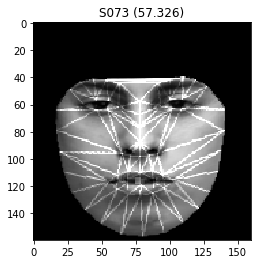

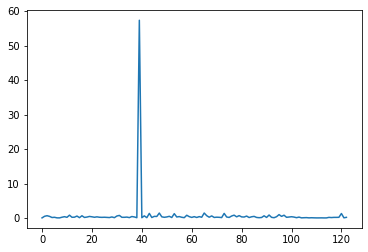

1474
Predicted: S068 (51.705)
Expected: S068


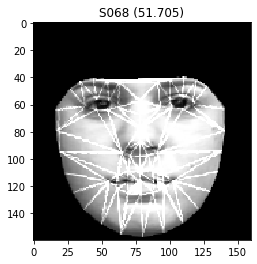

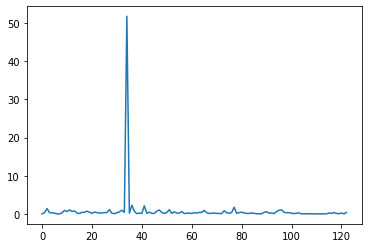

1016
Predicted: S113 (78.546)
Expected: S113


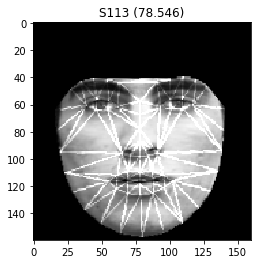

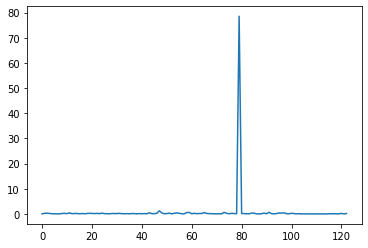

650
Predicted: S077 (54.153)
Expected: S077


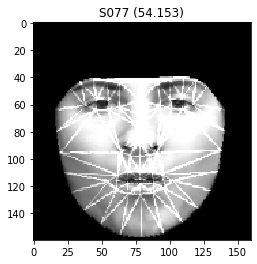

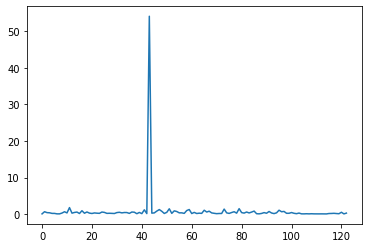

594
Predicted: S097 (62.038)
Expected: S097


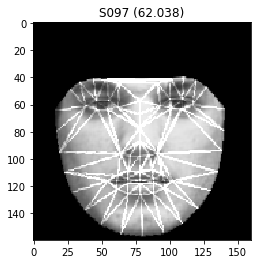

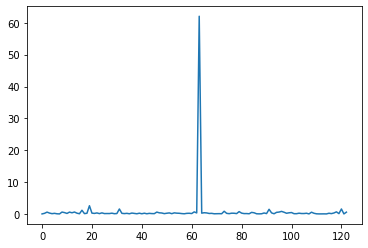

378
Predicted: S088 (41.239)
Expected: S088


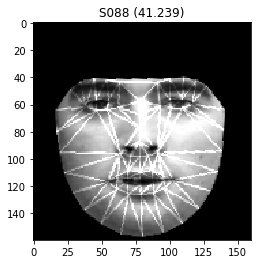

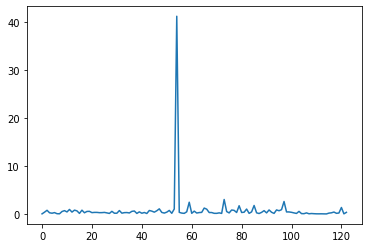

In [39]:
num_runs = 100
for ind in range(num_runs):
    # test model on a random example from the test dataset
    selection = choice([i for i in range(testX.shape[0])])
    print(selection)
    random_face_pixels = testX_faces[selection]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    yhat_prob = model_SVM.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    print('Expected: %s' % random_face_name[0])
    # plot for fun
    pyplot.imshow(random_face_pixels)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()
    pyplot.plot(yhat_prob.flatten() * 100)
    pyplot.show()